In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler as sc
digits = load_digits()
print(digits.images.shape)

(1797, 8, 8)


<Figure size 640x480 with 0 Axes>

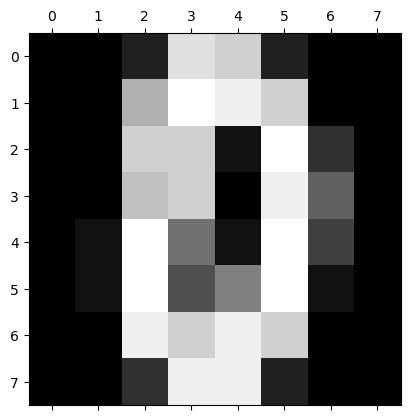

0


In [4]:
import pylab as pl
pl.gray()
pl.matshow(digits.images[1323])
pl.show()
print(digits.target[1323])

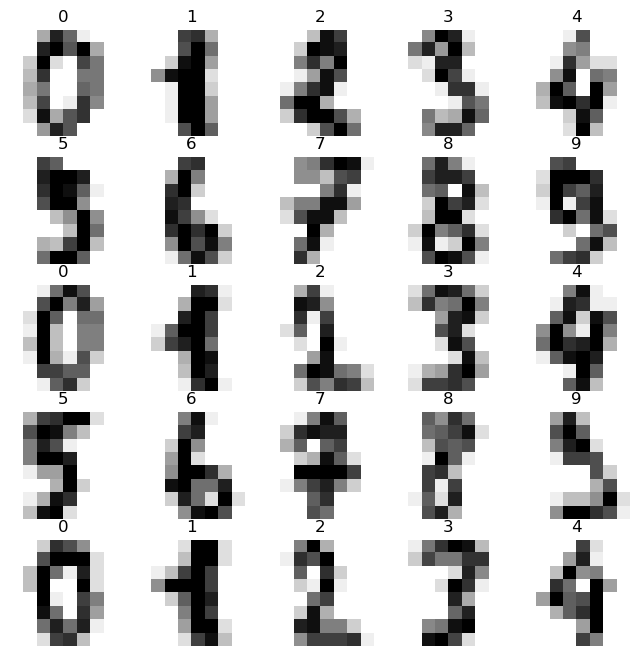

In [5]:
image_target=list(zip(digits.images,digits.target))
plt.figure(figsize=(8,8))
for i,(image,target) in enumerate(image_target[:25]):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title(target)

In [6]:
n = digits.images.shape[0]
print(n)

# 3D to 2D, so that we can work on it
x = digits.images.reshape(n,-1)
print(x.shape)

y = digits.target

# (1797,) to (1797,1), same reason
y = y.reshape(-1,1)
print(y.shape)

1797
(1797, 64)
(1797, 1)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)

(1437, 64)
(1437, 1)


In [8]:
# Standardising i.e. x = (x-u)/s
X_train = sc().fit_transform(X_train)
X_test = sc().fit_transform(X_test)

# Transpose

X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

print(X_train.shape)

(64, 1437)


In [9]:
n = y_train.shape[1]
Y_train_ = np.zeros((10,n))

# Y_train_, Y_test_ is a matrix, so that we can store 1 for all integers from 0 to 9, if it's the target

for i in range(n):
    Y_train_[y_train[0][i],i] = 1

Y_test_ = np.zeros((10,y_test.shape[1]))

for i in range(y_test.shape[1]):
    Y_test_[y_test[0][i],i] = 1

In [10]:
def sigmoid_(Z):
    return 1/(1+np.exp(-Z))

def sigmoid(Z):
    return sigmoid_(Z),Z

def dsigmoid(Z):
    return sigmoid_(Z)*(1-sigmoid_(Z))

def sigmoid_backward(dA,activation_cache):
    return dA* dsigmoid(activation_cache)

In [11]:
def relu_(Z):
    return Z*(Z>0)

def relu(Z):
    return relu_(Z),Z

def drelu(Z):
    return 1*(Z>0)

def relu_backward(dA,activation_cache):
    return dA* drelu(activation_cache)

In [12]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}         # dictionary to store the weights and biases for every layer, except 0th layer, which is input layer
    L = len(layer_dims) 
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

In [13]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)       # tuple to store them to use in backward propagation
    
    return Z, cache

In [14]:
def linear_activation_forward(A_prev,W,b,activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    
    return A, cache

In [15]:
def forward_propagation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2    # L rempresent number of layers
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")

    # For every layer, we use ReLU to avoid diminishing derivative problem, and sigmoid at the end.
    
    caches.append(cache)

    return AL, caches

In [16]:
def compute_cost(AL, Y):
    n=Y.shape[1]
    cost = -(1/n)*np.sum((Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    cost=np.squeeze(cost)

    return cost

In [17]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [18]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev,dW,db

In [19]:
def backward_propagation(AL, Y, caches):
    grads = {}          # Dictionary to store gradients after iteration of the loop
    L = len(caches)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

In [20]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-(learning_rate)*grads["dW"+str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate)*grads["db"+str(l+1)]
    
    return parameters

In [27]:
n=64            # number of layers
layers_dims=[n,60,10,10]

def train(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = forward_propagation(X, parameters)
        cost = compute_cost(AL, Y)
        grads = backward_propagation(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # Plotting
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 6.931433
Cost after iteration 1000: 3.262898
Cost after iteration 2000: 3.248166
Cost after iteration 3000: 3.234808
Cost after iteration 4000: 2.722599
Cost after iteration 5000: 1.930340
Cost after iteration 6000: 1.237044
Cost after iteration 7000: 0.767751
Cost after iteration 8000: 0.491657
Cost after iteration 9000: 0.341047
Cost after iteration 10000: 0.244711
Cost after iteration 11000: 0.172028
Cost after iteration 12000: 0.126399
Cost after iteration 13000: 0.096948
Cost after iteration 14000: 0.076117
Cost after iteration 15000: 0.060712
Cost after iteration 16000: 0.048979
Cost after iteration 17000: 0.040000
Cost after iteration 18000: 0.033183
Cost after iteration 19000: 0.027940
Cost after iteration 20000: 0.023885
Cost after iteration 21000: 0.020685
Cost after iteration 22000: 0.018118
Cost after iteration 23000: 0.016028
Cost after iteration 24000: 0.014305
Cost after iteration 25000: 0.012873
Cost after iteration 26000: 0.011666
Cost after ite

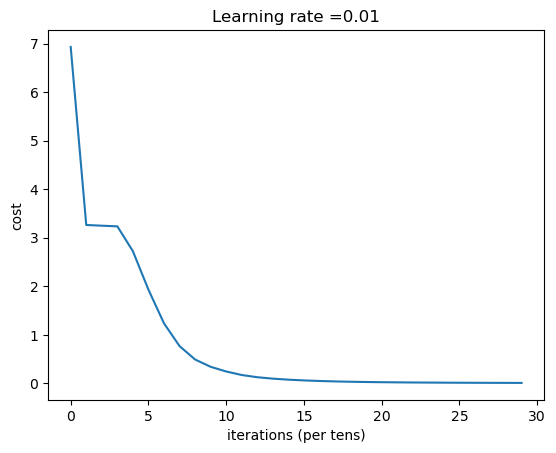

In [46]:
parameters = train(X_train, Y_train_, layers_dims, num_iterations = 30000, print_cost = True)

In [43]:
def predict(X,parameters):
    AL,caches=forward_propagation(X,parameters)
    prediction=np.argmax(AL,axis=0)

    return prediction.reshape(1,prediction.shape[0])

In [44]:
predictions_train = predict(X_train, parameters)
print("Training Accuracy : "+ str(np.sum(predictions_train==y_train)/y_train.shape[1] * 100)+"%")

Training Accuracy : 10.508002783576895%


In [45]:
print(X_test.shape)
predictions_test=predict(X_test,parameters)
print("Testing Accuracy : "+ str(np.sum(predictions_test==y_test)/y_test.shape[1] * 100)+" %")
print(predictions_test.shape)
print(predictions_test)

(64, 360)
Testing Accuracy : 8.333333333333332 %
(1, 360)
[[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]]
